In [1]:
# libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
import random

In [2]:
import subprocess

# download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# now can import the nltk resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [3]:
# download dataset
df = pd.read_csv('/kaggle/input/fake-news/FakeNewsNet.csv')

In [4]:
# check data length
len(df)

23196

In [5]:
# data review
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


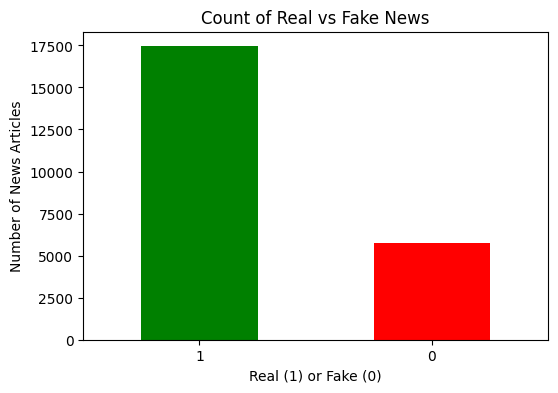

In [6]:
# count the number of real and fake news articles
real_fake_counts = df['real'].value_counts()

# plot of them
plt.figure(figsize=(6,4))
real_fake_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Count of Real vs Fake News')
plt.xlabel('Real (1) or Fake (0)')
plt.ylabel('Number of News Articles')
plt.xticks(rotation=0)
plt.show()

In [7]:
# download nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

# data preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# cleaning and refresh

def preprocess_text(text):
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_title'] = df['title'].apply(preprocess_text)

In [9]:
# random permutation of words

def shuffle_words(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

# generating new examples
df['shuffled_title'] = df['cleaned_title'].apply(shuffle_words)
df = pd.concat([df, df[['shuffled_title', 'real']]], ignore_index=True).drop(columns=['cleaned_title'])

In [10]:
# check 2
len(df)

46392

In [11]:
# tokenization

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['shuffled_title'])
X = tokenizer.texts_to_sequences(df['shuffled_title'])
X = pad_sequences(X, maxlen=100)
y = df['real'].values

In [12]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# building an LSTM-model with Bidirectional LSTM and regularization

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [14]:
# model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model training
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7578 - loss: 2.8487 - val_accuracy: 0.8373 - val_loss: 0.3960
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8568 - loss: 0.3714 - val_accuracy: 0.8534 - val_loss: 0.3673
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8842 - loss: 0.3082 - val_accuracy: 0.8637 - val_loss: 0.3451
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9003 - loss: 0.2719 - val_accuracy: 0.8712 - val_loss: 0.3505
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9107 - loss: 0.2526 - val_accuracy: 0.8691 - val_loss: 0.3467
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9137 - loss: 0.2466 - val_accuracy: 0.8747 - val_loss: 0.3348
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9151 - loss: 0.2444 - val_accuracy: 0.8731 - val_loss: 0.3475
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9241 - loss: 0.2261 - val_acc

In [16]:
# acc
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8943 - loss: 0.3462
Test accuracy: 0.90
